In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
images_dir ='/content/drive/MyDrive/Proyecto IA2/Data/images_cut'
masks_dir = '/content/drive/MyDrive/Proyecto IA2/Data/labels_cut'

In [6]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [7]:
image_size=512
input_image_size=(512,512)

In [8]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [9]:
number=200

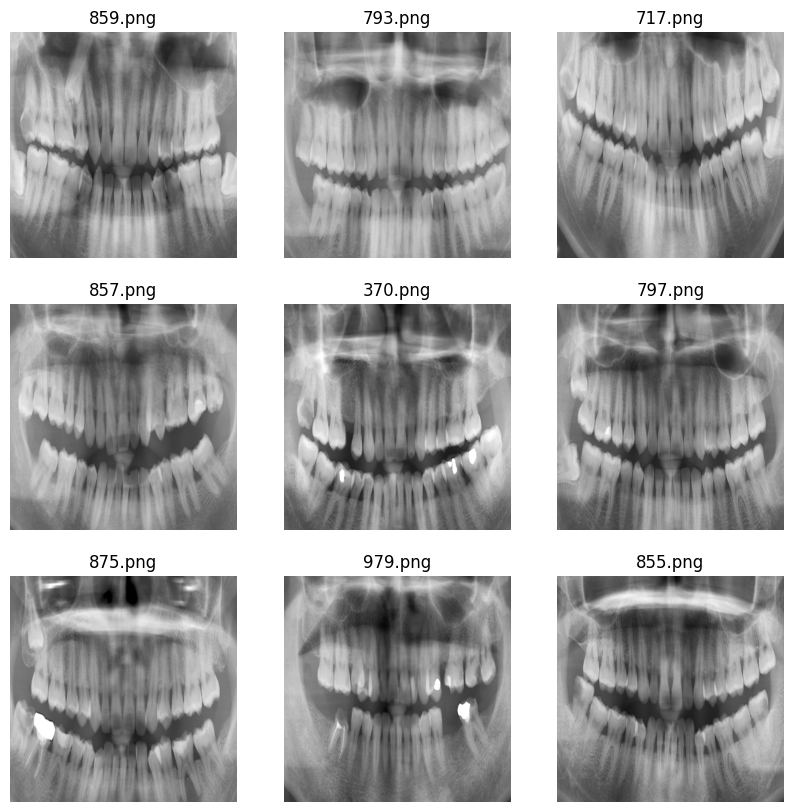

In [10]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

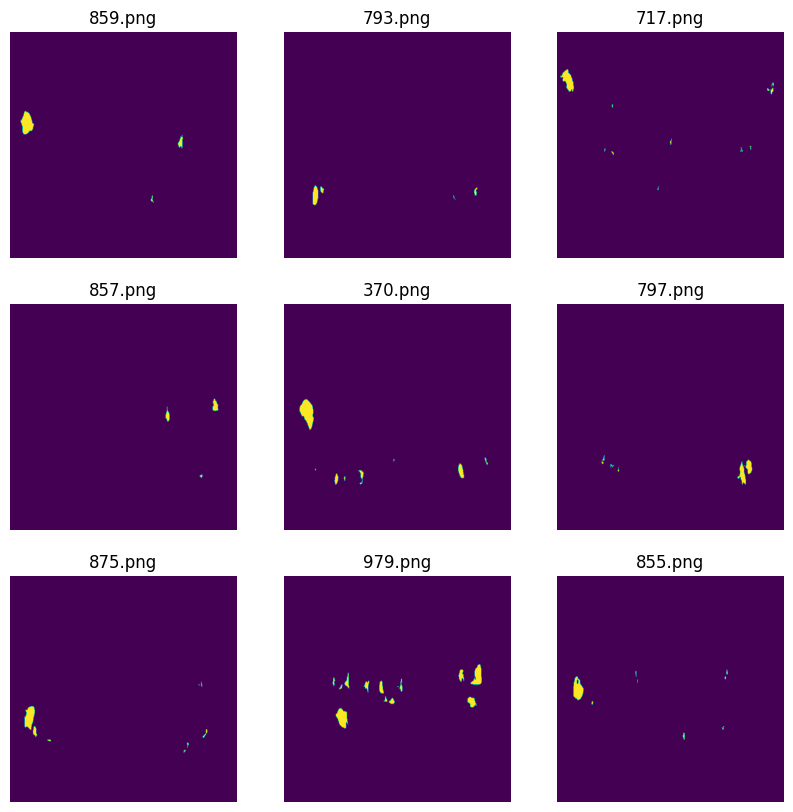

In [11]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [12]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [13]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.5, random_state=42)

In [15]:
inputs = tf.keras.layers.Input((512, 512, 3))

l1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
b1 = tf.keras.layers.BatchNormalization()(l1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

l2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
b2 = tf.keras.layers.BatchNormalization()(l2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

l3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
b3 = tf.keras.layers.BatchNormalization()(l3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

l4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
b4 = tf.keras.layers.BatchNormalization()(l4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

l5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(l5)
r5 = tf.keras.layers.ReLU()(b5)
l5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l5)

l6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(l5)
l6 = tf.keras.layers.concatenate([l6, l4])
l6 = tf.keras.layers.BatchNormalization()(l6)
l6 = tf.keras.layers.ReLU()(l6)

l7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(l6)
l7 = tf.keras.layers.concatenate([l7, l3])
l7 = tf.keras.layers.BatchNormalization()(l7)
l7 = tf.keras.layers.ReLU()(l7)

l8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(l7)
l8 = tf.keras.layers.concatenate([l8, l2])
l8 = tf.keras.layers.BatchNormalization()(l8)
l8 = tf.keras.layers.ReLU()(l8)

l9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(l8)
l9 = tf.keras.layers.concatenate([l9, l1], axis=3)
l9 = tf.keras.layers.BatchNormalization()(l9)
l9 = tf.keras.layers.ReLU()(l9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(l9)

In [16]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
history = model.fit(X_train, y_train, batch_size = 5, epochs = 10)

Epoch 1/10
10/10 [==============================] - 5s 458ms/step - loss: -92.8709 - accuracy: 0.4968
Epoch 2/10
10/10 [==============================] - 5s 461ms/step - loss: -97.6676 - accuracy: 0.5097
Epoch 3/10
10/10 [==============================] - 5s 465ms/step - loss: -106.1608 - accuracy: 0.5549
Epoch 4/10
10/10 [==============================] - 5s 471ms/step - loss: -118.5595 - accuracy: 0.5459
Epoch 5/10
10/10 [==============================] - 5s 473ms/step - loss: -130.1511 - accuracy: 0.5982
Epoch 6/10
10/10 [==============================] - 5s 480ms/step - loss: -149.2913 - accuracy: 0.5938
Epoch 7/10
10/10 [==============================] - 5s 481ms/step - loss: -161.7287 - accuracy: 0.5879
Epoch 8/10
10/10 [==============================] - 5s 474ms/step - loss: -177.1651 - accuracy: 0.5994
Epoch 9/10
10/10 [==============================] - 5s 470ms/step - loss: -189.3340 - accuracy: 0.5777
Epoch 10/10
10/10 [==============================] - 5s 469ms/step - loss: 

In [18]:
UNET = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto IA2/Modelo.h5')

In [19]:
preds_val = UNET.predict(X_test, verbose=1)

preds_val_t = (preds_val > 0.5)

2/2 [==============================] - 132s 42s/step


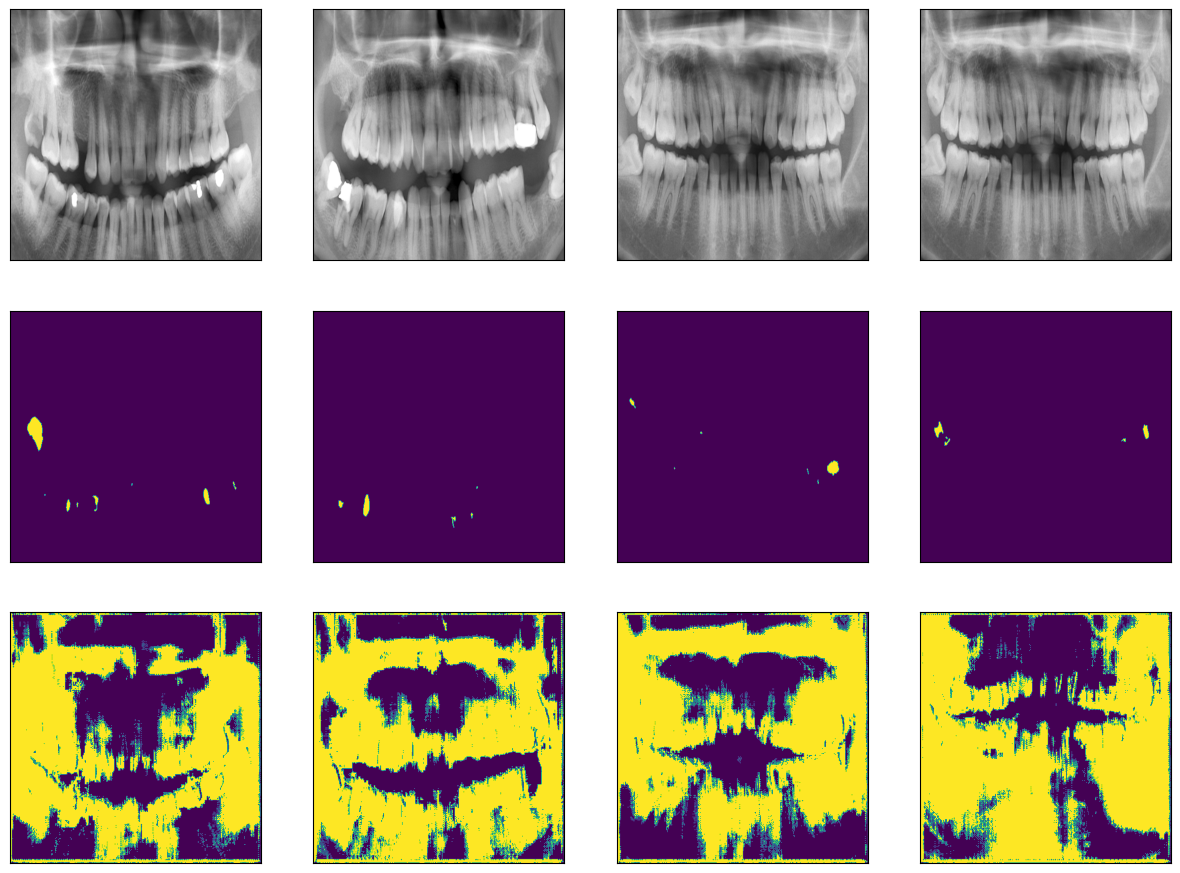

In [21]:
ex_1 =  5
ex_2 = 10
ex_3 = 20
ex_4 =  25

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_test[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_test[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_test[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_test[ex_3]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_test[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_test[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_test[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_test[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);